In [1]:
import pandas as pd
import seaborn as sns

"""
Class for running genetic algorithms
"""
# genetic algorithm search of the test coverage problem
from numpy.random import randint
from numpy.random import rand

class TestDatabase:
    # This class represents our test database
    # It is already implemented, no need to change it if you don't want

    def __init__(self):
        self.coverage=[]
        self.time=[]

    def get_time(self, i):
        return self.time[i]

    def get_coverage(self,i):
        return self.coverage[i]

    def get_number_of_tests(self):
        return len(self.time)

    def init_random(self,n_tests, max_time, max_code, p=0.05):
        # initialize a test database randomly
        self.coverage = []
        self.time = []

        for i in range(n_tests):
            t_time= randint(1,max_time)
            t_coverage=[]
            for i in range(1,max_code+1):
                if rand()<p:
                    t_coverage.append(i)
            self.time.append(t_time)
            self.coverage.append(t_coverage)


    def load_from_file(self,fn):
        # load test database from file with name fn
        # file format:
        #  line i represents test i as comma separated value
        #   the first value is the time to execute the test
        #   the other values are the lines covered by the test
        #  Example
        #   5, 1, 5, 7   -> A test that covers lines 1,5,7 and takes 5 seconds to run

        self.coverage = []
        self.time = []
        with open(fn,'rt') as fd:
            for line in fd.readlines():
                words=line.split(",")
                self.time.append(float(words[0]))
                self.coverage.append(list(map(lambda x: int(x), words[1:])))

    def write_to_file(self,fn):
        # write the test database to a file with name fn
        with open(fn, 'wt') as fd:
            for time, coverage in zip(self.time, self.coverage):
                fd.write(str(time))
                for i in coverage:
                    fd.write(", "+str(i))
                fd.write("\n")



In [17]:
import random

# fitness function, it is ready, no need to change it
def get_time_given_individual(x):
    total_time = 0
    for i in range(len(x)):
        if x[i] == 1:
            total_time = total_time + db.get_time(i)
    return total_time

def fitness(x, db, max_time):
    coverage  = set()
    total_time = 0

    for i in range(len(x)):
        if x[i] == 1:
            coverage = coverage.union( db.get_coverage(i))
            total_time = total_time + db.get_time(i)

    if total_time <= max_time:
        return len(coverage)
    else:
        return 0

def generate_custom_distribution(scores):
    total_score = sum(scores)
    probabilities = [sc / total_score for sc in scores]
    custom_distribution = {}
    for i, probability in enumerate(probabilities):
        custom_distribution[i] = probability
    return custom_distribution

def generate_linear_rank_distribution(scores):
    # Rank the indices based on scores
    # need to reverse because higher fitness should be better.
    ranked_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)

    population_size = len(scores)
    # create probabilities roulette
    probabilities = [(population_size - i) / ((population_size * (population_size + 1)) / 2) for i in range(0, population_size )]

    custom_distribution = {}
    for i, idx in enumerate(ranked_indices):
        custom_distribution[idx] = probabilities[i]

    return custom_distribution


def randomize_integer(custom_distribution):
    # Extract the values and probabilities from the custom distribution
    values = list(custom_distribution.keys())
    probabilities = list(custom_distribution.values())

    # Generate a random value based on the custom distribution
    randomized_value = random.choices(values, probabilities)[0]

    return randomized_value


# selection
def selection(population, scores):
    assert min(scores) >= 0, "All scores must be positive or 0! {}".format(scores)

    # TODO implement a (better) selection function
    # proportional fitness implementation
    # generate random distribution according to scores
    custom_distribution = generate_custom_distribution(scores)
    # random the individual to select
    selected_idx = randomize_integer(custom_distribution)

    return population[selected_idx]

def selection_rank(population, scores):
    """implementation of linear-rank selection from the book"""
    assert min(scores) >= 0, "All scores must be positive or 0! {}".format(scores)

    # TODO implement a (better) selection function
    # proportional fitness implementation
    # generate random distribution according to scores
    custom_distribution = generate_linear_rank_distribution(scores)
    # random the individual to select
    selected_idx = randomize_integer(custom_distribution)

    return population[selected_idx]

# crossover two parents to create two children
def crossover(p1, p2, r_cross):
    # TODO implement a (better) crossover function

    # children are copies of parents by default
    assert len(p1)-1 > 1, "the length of string is too short for crossover!"
    c1, c2 = p1.copy(), p2.copy() # keep the copy for no else
    if random.random() < r_cross: # crossover accepted
        # pick a point in length of children to cross over should be from index 1 till length -1
        cross_idx = random.randint(1, len(c1)-1) # note: randint is inclusive
        # crossover
        c1 = p1[:cross_idx] + p2[cross_idx:]
        c2 = p2[:cross_idx] + p1[cross_idx:]
    return [c1, c2]

# mutation operator
def mutation(bitstring, r_mut):
    # TODO implement a (better) mutation function
    for i in range(len(bitstring)):
        if random.random() < r_mut:
            bitstring[i] = 0 if bitstring[i] == 1 else 1
    return bitstring

# genetic algorithm
# This is ready, no need to change it if you don't want
def genetic_algorithm(db, maxtime, fitness, n_bits, n_iter, n_pop, r_cross, r_mut,
                      selection_fn=selection):
    # initial population of random bitstring
    population = []
    # initial population should have items with correct scores
    while len(population) < n_pop:
        c = randint(0, 2, n_bits).tolist()
        s = fitness(c, db, maxtime)
        if s > 0:
            population.append(c)
    # keep track of best solution
    best, best_eval = 0, fitness(population[0],db,maxtime)

    # enumerate generations
    for gen in range(n_iter):
        # evaluate all candidates in the population
        scores = [fitness(c,db,maxtime) for c in population]
        # remove population that has bad scores
        n_scores = []
        n_pops = []
        for i in range(n_pop):
            if scores[i] > 0:
                n_pops.append(population[i])
                n_scores.append(scores[i])
        scores = n_scores
        population = n_pops
        # check for new best solution
        for i in range(len(population)):
            if scores[i] > best_eval:
                best, best_eval = population[i], scores[i]
                print(">%d, new best f(%s) = %.3f" % (gen,  population[i], scores[i]))
        # select parents
        selected = [selection_fn(population, scores) for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
            # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                mutation(c, r_mut)
                # store for next generation
                children.append(c)
        # replace population
        population = children
    return [best, best_eval]


In [15]:
"""
Since in week 5 we implemented the basic (fitness proportion) deterministic Evolutionary Algorithm, in this week, we will implement the fitness ranked deterministic Evolutionary algorithm

Difference between 2 algorithms:
fitness proportion = use fitness as a base to determine probability of selecting an individual
ranked = use fitness to rank individual, this rank is then used as probability to select an individual.
Same concept: higher fitness = more likely to be selected
Difference: in ranked, no matter how high the fitness of an individual, it will not be more likely to be more selected - eg: no matter how much higher the fitness of top ranked individual compared to 2nd-highest rank individual is, the probability of being selected is the same. In fitness proportion -> if  (highest rank) is much better, he is way more likely to be selected.


How the original works: proportional fitness selection --> cumulative probabaility + random number --> routlette wheel style --> issue is with the super individual, negative fitness values need conversion - minimization problem need conversion, population lose diversity as it progress.

one of solution --> change fitness function as number of iterations increases

another method --> change your selection to ranking selection - calculated as function of rank rather than proportional fitness --> this is kinda similar to what i did in week 7 but with beta as selection pressure

another method --> tournament selection (what ivan did for week 5 if i recall correctly - wwe style) --> winner can win deterministically or stochastically.

tau -> takeover time (stronger = shorter) -> generally log(n) of population for only strong individuals to exist for most selection methods. generally it's this (mu + lambda) > tournament, ranking > proportional  in term of strength

# tehcnically i can try to do genetic programming but i'm too uninterested in that currently ( need to finish project before 1st of sept )
"""


"\nSince in week 5 we implemented the basic (fitness proportion) deterministic Evolutionary Algorithm, in this week, we will implement the fitness ranked deterministic Evolutionary algorithm\n\nDifference between 2 algorithms:\nfitness proportion = use fitness as a base to determine probability of selecting an individual\nranked = use fitness to rank individual, this rank is then used as probability to select an individual.\nSame concept: higher fitness = more likely to be selected\nDifference: in ranked, no matter how high the fitness of an individual, it will not be more likely to be more selected - eg: no matter how much higher the fitness of top ranked individual compared to 2nd-highest rank individual is, the probability of being selected is the same. In fitness proportion -> if  (highest rank) is much better, he is way more likely to be selected.\n\n\nHow the original works: proportional fitness selection --> cumulative probabaility + random number --> routlette wheel style --> i

In [18]:

# intialize the problem
db = TestDatabase()
db.load_from_file("problem1.txt")
max_time=1000

# define the total iterations, you can change this
n_iter = 1000
# bits: one bit per each test that may be executed
n_bits =  db.get_number_of_tests()
# define the population size, you can change this
n_pop = 100
# crossover rate, you can change this
r_cross = 0.9
# mutation rate, you can change this
r_mut = 1.0 / float(n_bits)

# perform the genetic algorithm search
result_df = pd.DataFrame()
best_list, time_list, score_list = [], [], []
for i in range(30):
    random.seed(i) # make sure experiment is replicable + different seed according to recommendation from the hitchhiker guide + lecture
    best, score = genetic_algorithm(db, max_time, fitness, n_bits, n_iter, n_pop, r_cross, r_mut, selection_fn=selection)
    score_list.append(score)
    best_list.append(best)
    time_list.append(get_time_given_individual(best))
result_df['proportion_fitness_scores'] = score_list

db = TestDatabase()
db.load_from_file("problem1.txt")
best_list, time_list, score_list = [], [], []

for i in range(30):
    random.seed(i) # make sure experiment is replicable + different seed according to recommendation from the hitchhiker guide + lecture
    best, score = genetic_algorithm(db, max_time, fitness, n_bits, n_iter, n_pop, r_cross, r_mut, selection_fn=selection_rank)
    score_list.append(score)
    best_list.append(best)
    time_list.append(get_time_given_individual(best))
result_df['ranked_fitness_scores'] = score_list


>0, new best f([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]) = 694.000
>0, new best f([1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0]) = 699.000
>0, new best f([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0]) = 709.000
>0, new best f([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]) = 713.000
>0, new best f([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]) = 723.000
>0, new best f([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 

,proportion_fitness_scores,ranked_fitness_scores
count,30.000000,30.0
mean,831.900000,866.0
std,4.596475,0.0
min,826.000000,866.0
25%,829.000000,866.0
50%,831.000000,866.0
75%,834.000000,866.0
max,842.000000,866.0


<AxesSubplot: xlabel='score', ylabel='selection_type'>

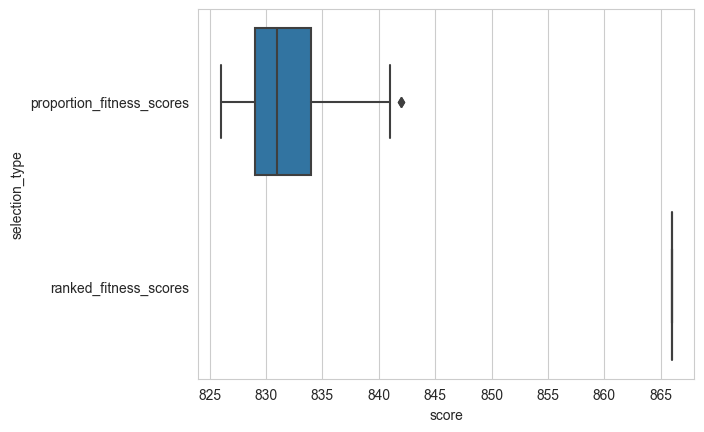

In [30]:
# descriptive statistics comparing both algorithm - variances, means
display(result_df.describe()) # change to print if not in jupyter notebook!
result_df.describe().to_csv('week8_1_description.csv')
# box plots of both items comparing them
import seaborn as sns
sns.boxplot(result_df.melt(var_name='selection_type', value_name='score'), x='score', y='selection_type')

In [21]:
import scipy
# man-whitney u statistics
def statistical_test(problem, fitness_scores, ranked_scores, significance=0.1):
    U,p = scipy.stats.mannwhitneyu(fitness_scores, ranked_scores, alternative="two-sided")
    print("The observed differences in the results of algorithm fitness_proportion and ranked_fitness for coverage of ",problem,"are ",end="")
    if p < significance:
        print("statistically significant.", end=" ")
    else:
        print("not statistically significant.", end=" ")
    print("Two-sided Mann–Whitney U test, significance level =",significance,", p-value = ",p)
statistical_test('problem1.txt', result_df['proportion_fitness_scores'],result_df['ranked_fitness_scores'], significance=0.05)

The observed differences in the results of algorithm fitness_proportion and ranked_fitness for coverage of  problem1.txt are statistically significant. Two-sided Mann–Whitney U test, significance level = 0.05 , p-value =  1.1699182694405219e-12


In [23]:
"""
Problem 2
"""

# intialize the problem
db = TestDatabase()
db.load_from_file("problem2.txt")
max_time=1000

# define the total iterations, you can change this
n_iter = 1000
# bits: one bit per each test that may be executed
n_bits =  db.get_number_of_tests()
# define the population size, you can change this
n_pop = 100
# crossover rate, you can change this
r_cross = 0.9
# mutation rate, you can change this
r_mut = 1.0 / float(n_bits)

# perform the genetic algorithm search
result_df2 = pd.DataFrame()
best_list, time_list, score_list = [], [], []
for i in range(30):
    random.seed(i) # make sure experiment is replicable + different seed according to recommendation from the hitchhiker guide + lecture
    best, score = genetic_algorithm(db, max_time, fitness, n_bits, n_iter, n_pop, r_cross, r_mut, selection_fn=selection)
    score_list.append(score)
    best_list.append(best)
    time_list.append(get_time_given_individual(best))
result_df2['proportion_fitness_scores'] = score_list

db = TestDatabase()
db.load_from_file("problem2.txt")
best_list, time_list, score_list = [], [], []

for i in range(30):
    random.seed(i) # make sure experiment is replicable + different seed according to recommendation from the hitchhiker guide + lecture
    best, score = genetic_algorithm(db, max_time, fitness, n_bits, n_iter, n_pop, r_cross, r_mut, selection_fn=selection_rank)
    score_list.append(score)
    best_list.append(best)
    time_list.append(get_time_given_individual(best))
result_df2['ranked_fitness_scores'] = score_list


>0, new best f([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]) = 704.000
>16, new best f([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]) = 709.000
>50, new best f([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]) = 731.000
>0, new best f([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1]) = 664.000
>0, new best f([1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]) = 671.000
>0, new best f([1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0

,proportion_fitness_scores,ranked_fitness_scores
count,30.000000,30.000000
mean,735.000000,766.300000
std,4.283086,0.702213
min,727.000000,765.000000
25%,732.000000,766.000000
50%,734.000000,766.000000
75%,737.000000,767.000000
max,746.000000,767.000000


The observed differences in the results of algorithm fitness_proportion and ranked_fitness for coverage of  problem2.txt are statistically significant. Two-sided Mann–Whitney U test, significance level = 0.05 , p-value =  1.828609692779135e-11


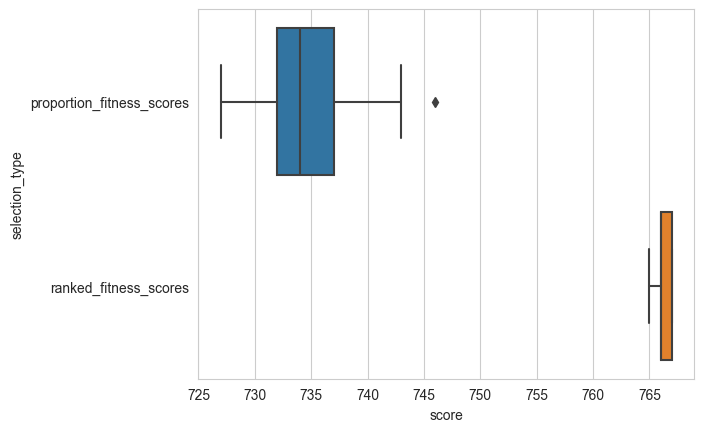

In [36]:
display(result_df2.describe()) # change to print if not in jupyter notebook!

sns.boxplot(result_df2.melt(var_name='selection_type', value_name='score'), x='score', y='selection_type')
statistical_test('problem2.txt', result_df2['proportion_fitness_scores'],result_df2['ranked_fitness_scores'], significance=0.05)


In [25]:
"""
Problem 3
"""

# intialize the problem
db = TestDatabase()
db.load_from_file("problem3.txt")
max_time=1000

# define the total iterations, you can change this
n_iter = 1000
# bits: one bit per each test that may be executed
n_bits =  db.get_number_of_tests()
# define the population size, you can change this
n_pop = 100
# crossover rate, you can change this
r_cross = 0.9
# mutation rate, you can change this
r_mut = 1.0 / float(n_bits)

# perform the genetic algorithm search
result_df3 = pd.DataFrame()
best_list, time_list, score_list = [], [], []
for i in range(30):
    random.seed(i) # make sure experiment is replicable + different seed according to recommendation from the hitchhiker guide + lecture
    best, score = genetic_algorithm(db, max_time, fitness, n_bits, n_iter, n_pop, r_cross, r_mut, selection_fn=selection)
    score_list.append(score)
    best_list.append(best)
    time_list.append(get_time_given_individual(best))
result_df3['proportion_fitness_scores'] = score_list

db = TestDatabase()
db.load_from_file("problem3.txt")
best_list, time_list, score_list = [], [], []

for i in range(30):
    random.seed(i) # make sure experiment is replicable + different seed according to recommendation from the hitchhiker guide + lecture
    best, score = genetic_algorithm(db, max_time, fitness, n_bits, n_iter, n_pop, r_cross, r_mut, selection_fn=selection_rank)
    score_list.append(score)
    best_list.append(best)
    time_list.append(get_time_given_individual(best))
result_df3['ranked_fitness_scores'] = score_list


>0, new best f([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]) = 659.000
>0, new best f([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]) = 662.000
>0, new best f([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0]) = 700.000
>0, new best f([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0]) = 709.000
>3, new best f([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]) = 721.000
>4, new best f([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 

,proportion_fitness_scores,ranked_fitness_scores
count,30.000000,30.0
mean,767.066667,804.0
std,4.884411,0.0
min,758.000000,804.0
25%,764.000000,804.0
50%,766.000000,804.0
75%,770.750000,804.0
max,778.000000,804.0


The observed differences in the results of algorithm fitness_proportion and ranked_fitness for coverage of  problem3.txt are statistically significant. Two-sided Mann–Whitney U test, significance level = 0.05 , p-value =  1.1747164315268844e-12


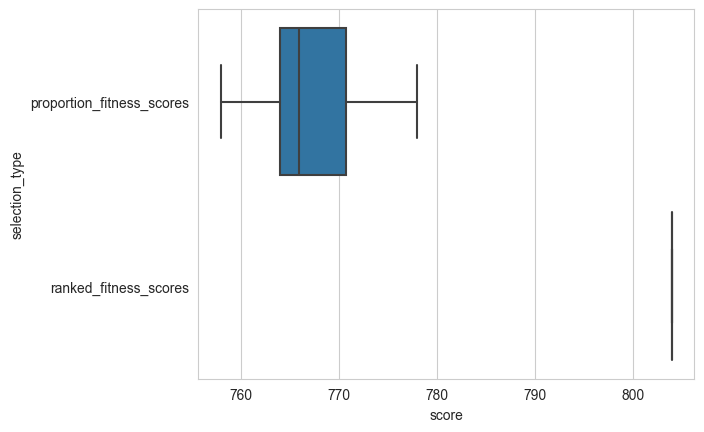

In [37]:
display(result_df3.describe()) # change to print if not in jupyter notebook!

sns.boxplot(result_df3.melt(var_name='selection_type', value_name='score'), x='score', y='selection_type')
statistical_test('problem3.txt', result_df3['proportion_fitness_scores'],result_df3['ranked_fitness_scores'], significance=0.05)
